### Import library

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Rescaling, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import pathlib
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

### Download dataset from kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arashnic/faces-age-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 104M/104M [00:01<00:00, 92.7MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/faces-age-detection-dataset/versions/2


In [ ]:
cp -r "/root/.cache/kagglehub/datasets/arashnic/faces-age-detection-dataset/versions/2" "/content/"

### Load dataset

In [ ]:
import pandas as pd
data = pd.read_csv("/content/2/faces/train.csv")
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [ ]:
data['Class'].value_counts()

,count
Class,
MIDDLE,10804
YOUNG,6706
OLD,2396


<Axes: >

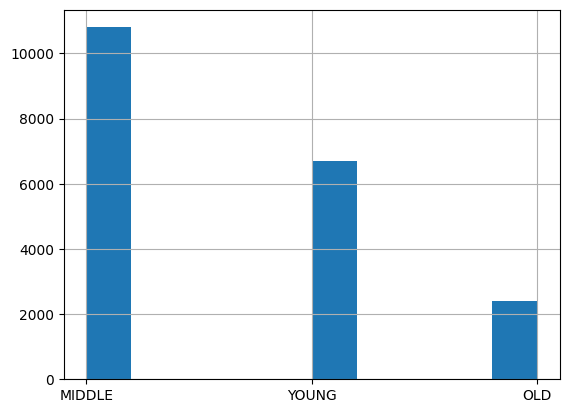

In [ ]:
# Create a histogram for all categories in the class variable.
data['Class'].hist()


In [ ]:
directory = "/content/2/faces/Train/"
data['filepath'] = directory + data['ID']

# Create DataFrame from the data
df_train = data[['filepath', 'Class']].rename(columns={'Class': 'label'})

# Check class distribution before splitting
print("Class distribution before splitting:")
print(df_train['label'].value_counts())

Class distribution before splitting:
label
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


### train test split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%), validation (10%), and test (10%) sets
train_df, dummy_df = train_test_split(df_train, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle=True, random_state=42)

# Print the shapes of the datasets
print(f"The shape of the Train data is: {train_df.shape}")
print(f"The shape of the Validation data is: {valid_df.shape}")
print(f"The shape of the Test data is: {test_df.shape}")

# Check class distribution in train_df
print("Class distribution in the Train data:")
print(train_df['label'].value_counts())

The shape of the Train data is: (15924, 2)
The shape of the Validation data is: (1991, 2)
The shape of the Test data is: (1991, 2)
Class distribution in the Train data:
label
MIDDLE    8623
YOUNG     5376
OLD       1925
Name: count, dtype: int64


In [ ]:
# Convert integer labels to strings for the data generators
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

### Augmentation image data generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator without augmentation
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 80

# Create data generators
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Validation Data")
validation_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Test Data")
test_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Check the class indices to ensure they are correct
print("Class indices:", train_ds.class_indices)


Training Data
Found 15924 validated image filenames belonging to 3 classes.
Validation Data
Found 1991 validated image filenames belonging to 3 classes.
Test Data
Found 1991 validated image filenames belonging to 3 classes.
Class indices: {'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


### plotting samples

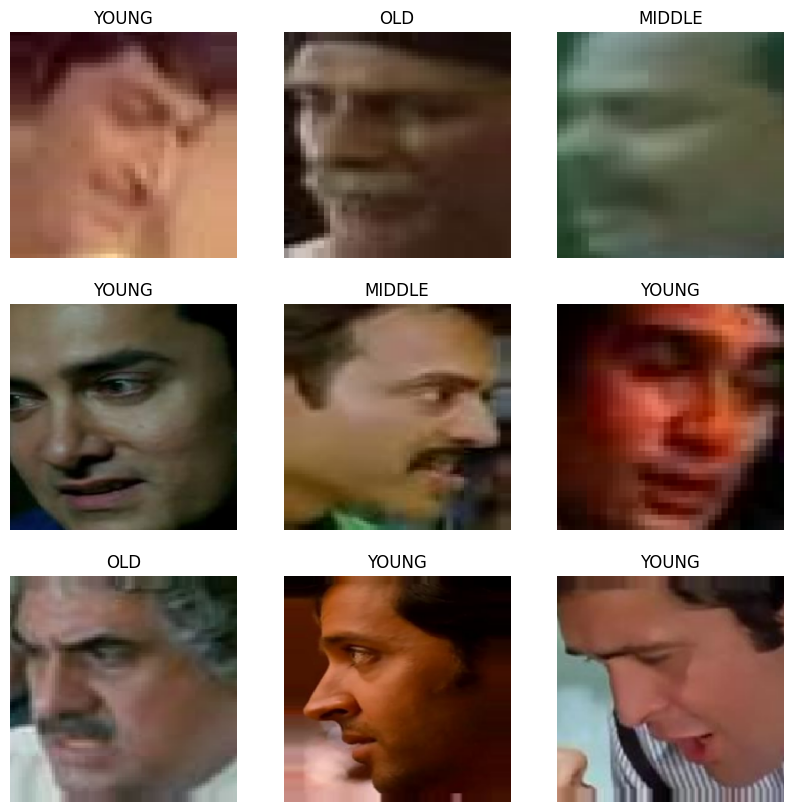

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Get a single batch of data
images, labels = next(train_ds)

# Assuming 'class_names' is defined somewhere and is accessible
class_names = list(train_ds.class_indices.keys()) # Infer class names from train_ds if not defined before

# Iterate and plot the images in the batch
for i in range(min(9, len(images))): # ensure we don't go beyond the batch size
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((255 * images[i]).astype('uint8')) # 'images[i]' is already a numpy array - remove '.numpy()'
    plt.title(class_names[np.argmax(labels[i])]) # Assuming 'labels' are one-hot encoded
    plt.axis('off')

plt.show()

### Transfer Learning

In [ ]:
from tensorflow.keras.applications import Xception
model = Sequential([
    Xception(weights='imagenet', include_top = False, input_shape=(256,256,3)),
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    # optimizer=Adam(learning_rate=0.0001/20, epsilon=1e-010),
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### training

In [ ]:
epochs = 20
history = model.fit(train_ds, validation_data=validation_ds, batch_size=batch_size, epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 533s 2s/step - accuracy: 0.5035 - loss: 6.4416 - val_accuracy: 0.6770 - val_loss: 2.7186
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.7064 - loss: 2.1272 - val_accuracy: 0.7454 - val_loss: 1.2225
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.7815 - loss: 0.9532 - val_accuracy: 0.4957 - val_loss: 2.4080
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.7550 - loss: 0.8588 - val_accuracy: 0.7981 - val_loss: 0.6368
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.8474 - loss: 0.4979 - val_accuracy: 0.8041 - val_loss: 0.5462
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.8709 - loss: 0.4060 - val_accuracy: 0.8307 - val_loss: 0.4939
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8544 - loss: 0.4643 - val_accuracy: 0.8127 - val_loss: 0.5496
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.8816 - loss: 0.3860 - val_accuracy: 0.852

### summary models

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 8, 8, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,168,323 (244.78 MB)

 Trainable params: 21,369,643 (81.52 MB)

 Non-trainable params: 59,392 (232.00 KB)

 Optimizer params: 42,739,288 (163.04 MB)

### learning curve

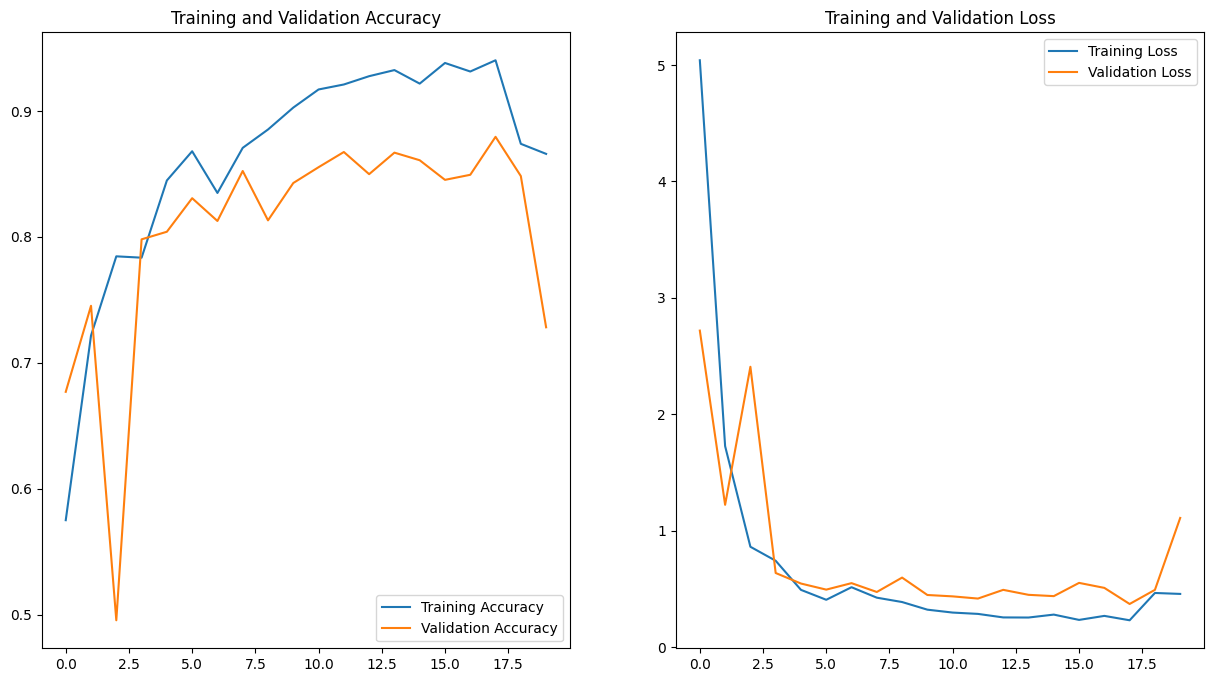

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['loss'], label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluating

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - accuracy: 0.7192 - loss: 1.0688
Test accuracy : 0.710698127746582
Test loss : 1.112939476966858
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/

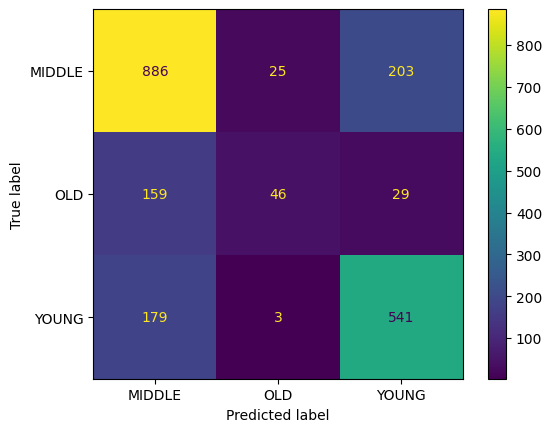

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print('Test loss :', loss)
y_true = []
y_pred = []
num_batches_to_process = min(200, len(test_ds))
# Iterate directly through the test_ds
for images, labels in test_ds:  # Changed from range(...) to test_ds
    batch_predictions = model.predict(images)
    batch_pred_labels = np.argmax(batch_predictions, axis=1)
    y_true.extend(labels.argmax(axis=1))  # Assuming labels are one-hot encoded
    y_pred.extend(batch_pred_labels)

    # Break loop to avoid processing the entire dataset if num_batches_to_process is less than the total number of batches
    if len(y_true) >= num_batches_to_process * batch_size:
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()


In [ ]:
tf.keras.models.save_model(model, 'exceptions.h5')

In [ ]:
from tensorflow.keras.layers import MaxPool2D
modelcnn = Sequential([

    Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),

    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(512, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),

    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(218, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

modelcnn.compile(
    optimizer='adam',
    # optimizer=Adam(learning_rate=0.0001/20, epsilon=1e-010),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
modelcnn.fit(train_ds, validation_data=validation_ds, batch_size=batch_size, epochs=epochs)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.4915 - loss: 1.3545 - val_accuracy: 0.5545 - val_loss: 1.0538
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.5428 - loss: 0.9534 - val_accuracy: 0.5555 - val_loss: 0.9504
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.5475 - loss: 0.9500 - val_accuracy: 0.5555 - val_loss: 0.9505
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.5415 - loss: 0.9627 - val_accuracy: 0.5555 - val_loss: 0.9497
Epoch 5/20
111/200 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.5414 - loss: 0.9596